# Homework for week08

> In this homework, we'll build a model for predicting if we have an image of a bee or a wasp. 
For this, we will use the "Bee or Wasp?" dataset that was obtained from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp) and slightly rebuilt. 


### Dataset

> You can download the dataset for this homework from [here](https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip):

```bash
wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
unzip data.zip
```


In [ ]:
# !wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
# !unzip data.zip

## Import Packages

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn as sk
import sys

import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensor Flow Version: 2.14.0
Python 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
Pandas 2.1.2
Scikit-Learn 1.3.1

Num GPUs Available:  1


In [16]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

In [17]:
from tensorflow import keras

from tensorflow.python.client import device_lib



In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

> **Note:** you will need an environment with a GPU for this homework. We recommend to use [Saturn Cloud](https://bit.ly/saturn-mlzoomcamp). 
> You can also use a computer without a GPU (e.g. your laptop), but it will be slower.


### Data Preparation

The dataset contains around 2500 images of bees and around 2100 images of wasps. 

The dataset contains separate folders for training and test sets. 


### Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check [Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).


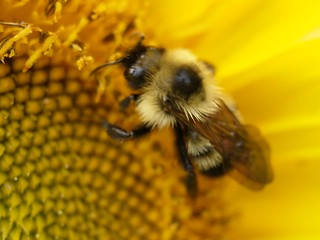

In [18]:
from tensorflow.keras.preprocessing.image import load_img
path = './data/train/bee'
name = '30593623_7199aec756_n.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

> The shape for input should be `(150, 150, 3)`

In [19]:
img = load_img(fullname, target_size=(150, 150))

In [20]:
x = np.array(img)
x.shape

(150, 150, 3)

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions


In [ ]:
# tf.keras.layers.Conv2D(
#     filters,
#     kernel_size,
#     strides=(1, 1),
#     padding="valid",
#     data_format=None,
#     dilation_rate=(1, 1),
#     groups=1,
#     activation=None,
#     use_bias=True,
#     kernel_initializer="glorot_uniform",
#     bias_initializer="zeros",
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )

In [ ]:
from tensorflow.keras.layers import Conv2D 
# The inputs are 28x28 RGB images with `channels_last` and the batch
# size is 4.
input_shape=(4, 150, 150, 3)
y = tf.keras.layers.Conv2D(
    filters=32, 
    kernel_size=(3, 3), activation='relu', input_shape=input_shape[1:])(x)
print(y.shape)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the input shape
input_shape = (150, 150, 3)

# Create a Sequential model
model = Sequential()

# Add a Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# Add a MaxPooling2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a Flatten layer
model.add(Flatten())

# Add a Dense layer with 64 neurons and 'relu' activation
model.add(Dense(units=64, activation='relu'))

# Add the output layer with 1 neuron and appropriate activation
model.add(Dense(units=1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11215873 (42.79 MB)
Trainable params: 11215873 (42.79 MB)
Non-trainable params: 0 (0.00 Byte)
______________

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

* `mean squared error`
* `binary crossentropy`
* `categorical crossentropy`
* `cosine similarity`

> **Note:** since we specify an activation for the output layer, we don't need to set `from_logits=True`




### Question 2

What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that. 

* 1 
* 65
* 896
* 11214912


### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/test directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets. 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
```


### Question 3

What is the median of training accuracy for all the epochs for this model?

* 0.20
* 0.40
* 0.60
* 0.80

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

* 0.31
* 0.61
* 0.91
* 1.31



### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=50,`
* `width_shift_range=0.1,`
* `height_shift_range=0.1,`
* `zoom_range=0.1,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`



### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.18
* 0.48
* 0.78
* 0.108


### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.38
* 0.58
* 0.78
* 0.98

